# A/B-тестирование

**Цель:** тестирование изменений, связанных с внедрением улучшенной рекомендательной системы.  

В рамках тестирования мы проведем оценку результатов A/B-теста на основании датасета с действиями пользователей, технического задания и нескольких вспомогательных датасетов:  
- оценим корректность проведения теста,
- проанализируем результаты теста.  

Чтобы оценить корректность проведения теста, выполним проверку:
- пересечения тестовой аудитории с конкурирующим тестом,
- совпадения теста и маркетинговых событий, других проблем временных границ теста.

**Гипотезы исследования**:

- за 14 дней с момента регистрации пользователи покажут улучшение метрики "Конверсия в просмотр карточек товаров - событие" не менее, чем на 10%;
- за 14 дней с момента регистрации пользователи покажут улучшение метрики "Просмотры корзины" не менее, чем на 10%;
- за 14 дней с момента регистрации пользователи покажут улучшение метрики "Покупки" не менее, чем на 10%.

**Этапы исследования:**

1. [Обзор данных](#h1)
2. [Предварительная обработка данных](#h2)
3. [Приведение данных в соответствие с техническим заданием](#h3)
4. [Исследовательский анализ данных](#h4)  
5. [Анализ результатов А/В-теста](#h5)
6. [Вывод](#h6)

<a name="h1"></a>
### 1. Обзор данных

#### Импорт библиотек

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np
import math as mth
from scipy import stats as st

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#### Настройка

In [2]:
#отображение всех данных из ячейки
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#отображение данных до двух знаков после запятой
pd.set_option('display.precision', 2)

#### Анализ файлов

In [3]:
ab_project_marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
final_ab_new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
final_ab_events = pd.read_csv('/datasets/final_ab_events.csv')
final_ab_participants = pd.read_csv('/datasets/final_ab_participants.csv')

##### Календарь маркетинговых событий на 2020 год

In [4]:
ab_project_marketing_events.head(14)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [5]:
ab_project_marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null object
regions      14 non-null object
start_dt     14 non-null object
finish_dt    14 non-null object
dtypes: object(4)
memory usage: 576.0+ bytes


##### Пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года

In [6]:
final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [7]:
final_ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null object
region        61733 non-null object
device        61733 non-null object
dtypes: object(4)
memory usage: 1.9+ MB


##### События новых пользователей в период с 7 декабря 2020 по 4 января 2021 года

In [8]:
final_ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [9]:
final_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null object
event_name    440317 non-null object
details       62740 non-null float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


##### Таблица участников тестов

In [10]:
final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [11]:
final_ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
user_id    18268 non-null object
group      18268 non-null object
ab_test    18268 non-null object
dtypes: object(3)
memory usage: 428.3+ KB


**Вывод**  
В нашем распоряжении датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов. Уже при беглом анализе можно выделить несколько моментов, на которые стоит обратить внимание:  
- *совпадение теста и маркетинговых событий*  
Даты проведения тестирования совпадают с рождественскими и новогодними праздниками в Европе и Северной Америке. В предпраздничные дни спрос значительно увеличивается и без влияния вспомогательных факторов, поэтому тестирование изменений на горизонте 14 дней не имеет смысла, так как полученные результаты будут нерепрезентативными. В качестве альтернативы можно было бы провести сравнение с показателями прошлого года за аналогичный период, если в течение года не было других значительных нововведений. 
- *наличие пропусков в `final_ab_events[details]`*  
Необходимо проверить по каким именно событиям не указаны детали. Вполне возможно, что пропуски логичны и не требуют отдельной проработки.  
- *некорректные типы данных в колонках с датами*  
Проблема актуальна для каждого датасета. Преобразуем информацию на этапе предварительной обработки данных.  
- *корректность представленной информации*  
Поскольку у нас есть техническое задание с точными требованиями к данным, необходимо проверить, что анализируемая информация полностью соответствует предъявляемым критериям.  

Таким образом, для исследования нам необходимо подготовить данные:  
- изменить тип данных в датах;
- исключить дубликаты при необходимости;
- определить и заполнить/исключить/оставить без изменений пропущенные значения там, где это необходимо;
- привести данные в соответствие с техническим заданием.

<a name="h2"></a>
### 2. Предварительная обработка данных

#### Изменение типа данных

Применим *pd.to_datetime* для изменения типа данных в столбцах с датами.

In [12]:
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'], format="%Y-%m-%d")
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'], format="%Y-%m-%d")

In [13]:
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'], format="%Y-%m-%d")

In [14]:
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'], format="%Y-%m-%d").dt.floor('D')

Проверим результат

In [15]:
ab_project_marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null object
regions      14 non-null object
start_dt     14 non-null datetime64[ns]
finish_dt    14 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [16]:
final_ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null datetime64[ns]
region        61733 non-null object
device        61733 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


In [17]:
final_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null datetime64[ns]
event_name    440317 non-null object
details       62740 non-null float64
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


**Результат:** типы данных изменены корректно.

#### Проверка дубликатов

Воспользуемся *duplicated.sum()* для выявления дублирующихся строк и значений.

In [18]:
ab_project_marketing_events.duplicated().sum()

0

In [19]:
final_ab_new_users['user_id'].duplicated().sum()

0

In [20]:
final_ab_events.duplicated().sum()

2

In [21]:
final_ab_participants['user_id'].duplicated().sum()

1602

В таблице с участниками теста есть дубликаты. Рассмотрим их подробнее.

In [22]:
duplicates = final_ab_participants[final_ab_participants['user_id'].duplicated()]

In [23]:
duplicates.head()

,user_id,group,ab_test
6702,773ECB64E45DEBAB,A,interface_eu_test
6704,AABA4219186465C9,A,interface_eu_test
6705,2BA8FA8754D1FE50,B,interface_eu_test
6706,FB6F6BC119E1DBD5,B,interface_eu_test
6715,0ABA6D32AE7AFB9B,A,interface_eu_test


In [24]:
duplicates['ab_test'].value_counts()

interface_eu_test    1602
Name: ab_test, dtype: int64

Некоторые пользователи принимали участие в двух тестах сразу: *recommender_system_test* и *interface_eu_test*. Такое наложение ставит под вопрос "чистоту" тестирования и, соответственно, полученных результатов. Исключим из выборки таких пользователей, а также участников других тестов. Для этого:
- составим список "двойных агентов" и удалим их из выборки;
- очистим выборку от участников других тестирований и убедимся, что дубликатов больше не осталось.

In [25]:
double_participants = duplicates['user_id'].to_list()

In [26]:
final_ab_participants = final_ab_participants.query('user_id != @double_participants')

In [27]:
final_ab_participants = final_ab_participants[final_ab_participants['ab_test'] == 'recommender_system_test']

In [28]:
final_ab_participants['user_id'].duplicated().sum()

0

Дубликатов больше нет - в датасете остались только те пользователи, которые приняли участие только в целевом тестировании. Также можно отметить, что в выборке нет пользователей, которые являлились бы участниками двух групп (А и В) одновременно. 

**Результат:** мы избавились от дублирующихся значений в датасете `final_ab_participants`, исключив данные по нерелевантному тестированию и данные по участникам нескольких тестирований сразу. Факт участия одних и тех же пользователей сразу в нескольких тестах ставит под вопрос "чистоту" каждого эксперимента. 

#### Анализ пропущенных значений

Пропуски были обнаружены только в датасете `final_ab_events`. Проверим для каких событий не заполнен столбец `details`

In [29]:
final_ab_events['event_name'].value_counts() 

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

In [30]:
final_ab_events[final_ab_events['details'].isnull()]['event_name'].value_counts() 

login           189552
product_page    125563
product_cart     62462
Name: event_name, dtype: int64

**Результат:** пропуски обоснованы - детали указаны только для покупок (стоимость заказа). Дополнительная обработка не требуется.

<a name="h3"></a>
### 3. Приведение данных в соответствие с техническим заданием

На предыдущем этапе из датасета `final_ab_participants` мы исключили нерелевантных пользователей. Составим список участников А/В-тестирования.

In [31]:
ab_participants = final_ab_participants['user_id'].to_list()

Исключим из `final_ab_events` события, произошедшие до или после дат проведения теста

In [32]:
final_ab_events = final_ab_events[(final_ab_events['event_dt'] >= '2020-12-07') & 
                                  (final_ab_events['event_dt'] <= '2021-01-04')]

In [33]:
final_ab_events['event_dt'].describe()

count                  440317
unique                     24
top       2020-12-21 00:00:00
freq                    32559
first     2020-12-07 00:00:00
last      2020-12-30 00:00:00
Name: event_dt, dtype: object

В представленных данных отсутствует информация о действиях пользователей за последние 5 дней тестирования: 31.12.2020-04.01.2021, поэтому для участников, зарегистрированных после 17.12.2020, не представляется возможным оценить эффект от изменений спустя 14 дней после регистрации. Исключим их из датасета `final_ab_new_users`. Также необходимо очистить указанный датасет от пользователей, не принимающих участия в А/В-тестировании.

In [34]:
#исключаем пользователей, зарегистрировавшихся позже 17.12.2020
final_ab_new_users = final_ab_new_users[(final_ab_new_users['first_date'] >= '2020-12-07') & 
                                        (final_ab_new_users['first_date'] <= '2020-12-18')]

In [35]:
#исключаем пользователей, не являющихся участниками А/В-тестирования
final_ab_new_users = final_ab_new_users.query('user_id == @ab_participants')

In [36]:
final_ab_new_users['user_id'].describe()

count                 3832
unique                3832
top       B5B015BA0DDFF83F
freq                     1
Name: user_id, dtype: object

Осталось всего 3 832 пользователя, по которым можно оценить эффект от внедрения новой системы спустя 14 дней после регистрации. Обновим значение списка участников (`ab_participants`).

In [37]:
ab_participants = final_ab_new_users['user_id'].to_list()

Оставим в датасетах `final_ab_events` и `final_ab_participants` только данные по пользователям из актуализированного списка `ab_participants`

In [38]:
final_ab_events = final_ab_events.query('user_id == @ab_participants')

In [39]:
final_ab_participants = final_ab_participants.query('user_id == @ab_participants')

Дополним таблицу `final_ab_events` информацией о дате регистрации пользователей и принадлежности к группе тестирования

In [40]:
final_ab_events = final_ab_events.merge(final_ab_participants, on='user_id', how='left')
final_ab_events = final_ab_events.merge(final_ab_new_users, on='user_id', how='left')

In [41]:
final_ab_events.head()

,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device
0,831887FE7F2D6CBA,2020-12-07,purchase,4.99,A,recommender_system_test,2020-12-07,EU,Android
1,3C5DD0288AC4FE23,2020-12-07,purchase,4.99,A,recommender_system_test,2020-12-07,EU,PC
2,49EA242586C87836,2020-12-07,purchase,99.99,B,recommender_system_test,2020-12-07,EU,iPhone
3,A640F31CAC7823A6,2020-12-07,purchase,4.99,B,recommender_system_test,2020-12-07,EU,PC
4,A9908F62C41613A8,2020-12-07,purchase,9.99,B,recommender_system_test,2020-12-07,EU,PC


In [42]:
final_ab_events.isnull().sum()

user_id           0
event_dt          0
event_name        0
details       11626
group             0
ab_test           0
first_date        0
region            0
device            0
dtype: int64

Данные добавлены. Ожидаемые пропуски только в графе *details*.  

Добавим информацию по принадлежности к группе тестирования в датасет `final_ab_new_users` и проверим результат

In [43]:
final_ab_new_users = final_ab_new_users.merge(final_ab_participants, on='user_id', how='left')

In [44]:
final_ab_new_users.head()

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,831887FE7F2D6CBA,2020-12-07,EU,Android,A,recommender_system_test
2,4CB179C7F847320B,2020-12-07,EU,iPhone,B,recommender_system_test
3,29C92313A98B1176,2020-12-07,APAC,Android,B,recommender_system_test
4,7D1BFB181017EB46,2020-12-07,CIS,PC,B,recommender_system_test


In [45]:
final_ab_new_users.isnull().sum()

user_id       0
first_date    0
region        0
device        0
group         0
ab_test       0
dtype: int64

Сгруппируем новых пользователей по регионам

In [46]:
final_ab_new_users_groupby = final_ab_new_users.groupby('region').agg({'user_id':'count'}).reset_index()

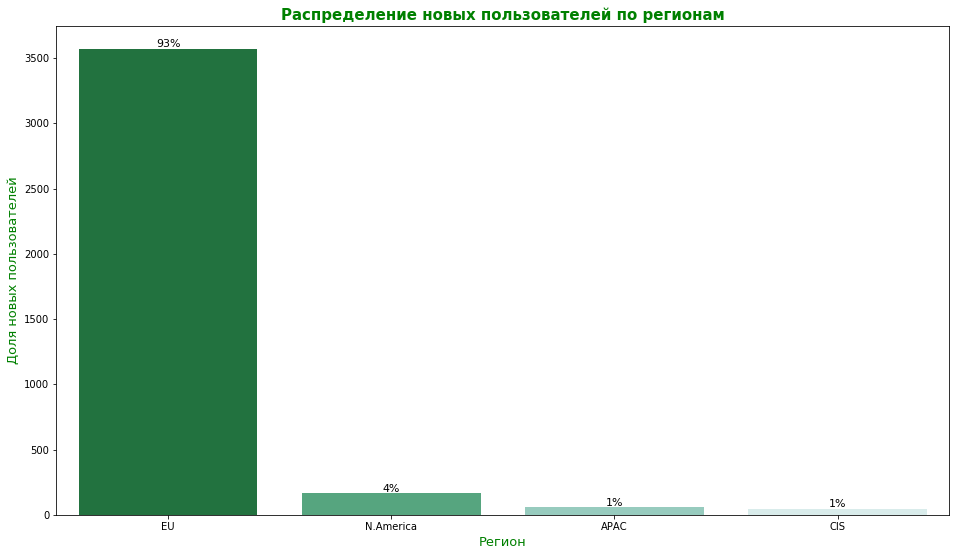

In [47]:
plt.figure(figsize=(16,9))
ax = sns.barplot(x='region', y='user_id', data=final_ab_new_users_groupby.sort_values('user_id', ascending=False), 
                 palette=sns.color_palette("BuGn_r",  len(final_ab_new_users_groupby)))

for p in ax.patches:
    height = p.get_height()
    if np.isnan(height):
        height = 0
    ax.text(p.get_x() + p.get_width()/2., height, '{0:.0%}'.format(height/len(final_ab_new_users)), 
            fontsize=11, color='black', ha='center', va='bottom')
    
plt.title('Распределение новых пользователей по регионам', fontsize = 15, fontweight="bold", color='green')
plt.xlabel("Регион", fontsize = 13, fontweight=500, color='green')
plt.ylabel("Доля новых пользователей", fontsize = 13, fontweight=500, color='green');

Доля участников из Европы составляет 93% от всех новых пользователей, что исказит результаты тестирования, поскольку сроки проведения теста совпадают с рождественскими и новогодними праздниками в этом регионе. Снижение количества европейцев до требуемого уровня (15%) не представляется возможным, поскольку приведет к сокращению выборки на 92%.

**Результат:** Определили список участников А/В-тестирования, оставили в дататсетах `final_ab_new_users` и `final_ab_events` данные только по выбранным пользователям, в указанные в техническом задании временные промежутки с учетом возможности оценки результатов по истечении 14-дневного срока.

<a name="h4"></a>
### 4. Исследовательский анализ данных

Рассмотрим сколько пользователей в каждой группе совершали каждое из событий

In [48]:
#разбиваем уникальных пользователей по событиям и группам 
events_by_group = final_ab_events.groupby(['event_name', 'group']).agg(
    {'user_id':'nunique'}).reset_index().sort_values('user_id', ascending=False)

In [49]:
events_by_group

,event_name,group,user_id
0,login,A,1359
4,product_page,A,891
1,login,B,554
2,product_cart,A,430
6,purchase,A,407
5,product_page,B,306
3,product_cart,B,161
7,purchase,B,149


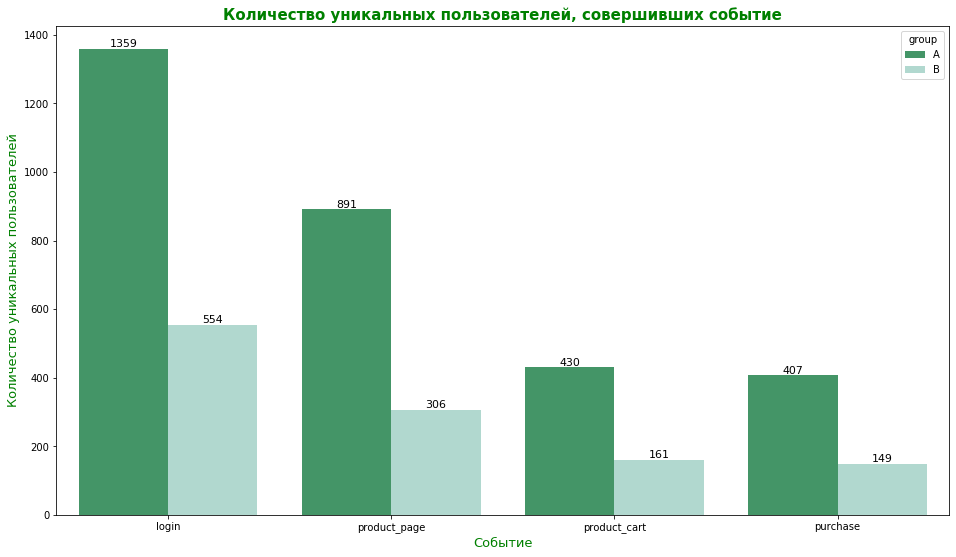

In [50]:
plt.figure(figsize=(16,9))
ax = sns.barplot(x='event_name', y='user_id', data=events_by_group, hue='group',
                 palette=sns.color_palette("BuGn_r", 2))

for p in ax.patches:
    height = p.get_height()
    if np.isnan(height):
        height = 0
    ax.text(p.get_x() + p.get_width()/2., height, '%d' % int(height), 
        fontsize=11, color='black', ha='center', va='bottom')
    
plt.title("Количество уникальных пользователей, совершивших событие", fontsize = 15, fontweight="bold", color='green')
plt.xlabel("Событие", fontsize = 13, fontweight=500, color='green')
plt.ylabel("Количество уникальных пользователей", fontsize = 13, fontweight=500, color='green');

На графике четко виден дисбаланс разбивки пользователей на группы **А** и **В** - первых примерно в 2,5 раза больше, чем вторых, что вносит очередную долю погрешности в тестирование (особенно, если речь идет об абсолютных показателях, так как для относительных показателей последствия могут быть не столь критичны). Тем не менее, исходя из полученной информации можно определить воронку событий:

- вход на сайт;
- просмотр карточки товара;
- просмотр корзины;
- покупка.  

Рассчитаем конверсию методом *shift*

In [51]:
#формируем сводную таблицу по событиям и группам тестирования
events_pivot = events_by_group.pivot_table(index='event_name',columns='group',
                                             values='user_id').sort_values('A', ascending=False)

In [52]:
#рассчитываем конверсию для каждой группы
events_pivot['conversion_A'] = events_pivot.A / events_pivot.A.shift(1)
events_pivot['conversion_B'] = events_pivot.B / events_pivot.B.shift(1)

In [53]:
events_pivot

group,A,B,conversion_A,conversion_B
event_name,,,,
login,1359,554,NaN,NaN
product_page,891,306,0.66,0.55
product_cart,430,161,0.48,0.53
purchase,407,149,0.95,0.93


In [54]:
print('Доля пользователей группы А, вошедших на сайт и дошедших до этапа покупки:', 
      np.round((events_pivot.iloc[3,0] / events_pivot.iloc[0,0]), 2))
print('Доля пользователей группы В, вошедших на сайт и дошедших до этапа покупки:', 
      np.round((events_pivot.iloc[3,1] / events_pivot.iloc[0,1]), 2))

Доля пользователей группы А, вошедших на сайт и дошедших до этапа покупки: 0.3
Доля пользователей группы В, вошедших на сайт и дошедших до этапа покупки: 0.27


В целом динамики конверсий группы **А** и группы **В** схожи, однако показатели первой группы лучше - доля пользователей группы **А**, вошедших на сайт и дошедших до этапа покупки на 10% больше, чем у группы **В**.
Больше всего пользователей отсеивается после просмотра карточек товаров - только каждый второй переходит после этого этапа в корзину.

In [55]:
print('На одного пользователя группы А в среднем приходится', round(
    len(final_ab_events[final_ab_events['group'] == 'A']) 
    / len(final_ab_new_users[final_ab_new_users['group'] == 'A'])), 'событий')

print('На одного пользователя группы B в среднем приходится', round(
    len(final_ab_events[final_ab_events['group'] == 'B']) 
    / len(final_ab_new_users[final_ab_new_users['group'] == 'B'])), 'события')

На одного пользователя группы А в среднем приходится 5 событий
На одного пользователя группы B в среднем приходится 2 события


Пользователи группы **А** более активны, чем пользователи группы **В**.  

Рассмотрим как число событий распределяется по дням.

In [56]:
events_by_days = final_ab_events.groupby(['event_dt', 'group']).agg({'event_name':'count'}).reset_index()

events_by_days_A = events_by_days[events_by_days['group'] == 'A']
events_by_days_B = events_by_days[events_by_days['group'] == 'B']

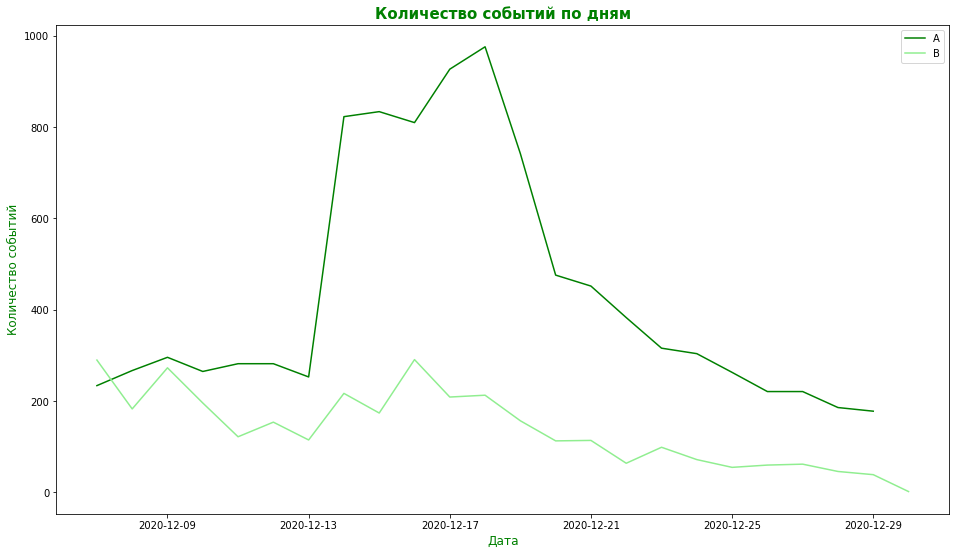

In [57]:
plt.figure(figsize=(16,9))

plt.plot(events_by_days_A['event_dt'], events_by_days_A['event_name'], label='A', color='green')
plt.plot(events_by_days_B['event_dt'], events_by_days_B['event_name'], label='B', color='lightgreen')

plt.title("Количество событий по дням", fontsize = 15, fontweight="bold", color='green')
plt.xlabel("Дата", fontsize = 12, fontweight=500, color='green')
plt.ylabel('Количество событий', fontsize = 12, fontweight=500, color='green')
plt.legend();

Пик событий пришелся на период с 14 по 19 декабря (что особенно заметно по группе А). Скорее всего рост обусловлен предпраздничным ажиотажем.

**Вывод**  
Анализ представленных данных выявил ряд нарушений, допущенных при проведении тестирования:
- период теста совпал с рождественскими и новогодними праздниками в Европе и Северной Америке, при этом более 95% новых зарегистрированных пользователей проживают в указанных регионах, что не позволяет адекватно оценить влияние внедрения улучшенной рекомендательной системы на метрики;
- одни и те же пользователи принимали участие как минимум в двух разных тестах одновременно, что не позволяет оценить эффект от каждого отдельного изменения;
- участники были неравномерно поделены на группы А и В как по количеству, так и по качеству. Участники группы А не только значительно превышают группу В по количеству, но и в принципе являются более более активными пользователями, совершая в среднем в 2,5 раза больше действий на сайте.

<a name="h5"></a>
### 5. Анализ результатов А/В-теста

Еще раз рассмотрим конверсию в воронках по группе **А** и группе **В**

In [58]:
events_pivot

group,A,B,conversion_A,conversion_B
event_name,,,,
login,1359,554,NaN,NaN
product_page,891,306,0.66,0.55
product_cart,430,161,0.48,0.53
purchase,407,149,0.95,0.93


И проверим статистическую значимость долей z-критерием

In [59]:
alpha = 0.01 # критический уровень статистической значимости                 

for event in range(1, 4):
    successes = np.array([events_pivot.iloc[event, 0], events_pivot.iloc[event, 1]])
    trials = np.array([events_pivot.iloc[event-1, 0], events_pivot.iloc[event-1, 1]])

    # пропорция успехов в каждой группе относительно прошлого события:
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2
   
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('Нулевая гипотеза H₀: конверсии группы А и группы В по событию', events_pivot.index[event], 'равны.')
    print('Альтернативная гипотеза H₁: конверсии группы А и группы В по событию', events_pivot.index[event], 'различаются.')
    print('p-значение: ', round(p_value, 4))
    
    if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между конверсиями есть значимая разница")
    else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными")
    print('---------------------------------------------------------------------------------------------------------------')
    print()

Нулевая гипотеза H₀: конверсии группы А и группы В по событию product_page равны.
Альтернативная гипотеза H₁: конверсии группы А и группы В по событию product_page различаются.
p-значение:  0.0
Отвергаем нулевую гипотезу: между конверсиями есть значимая разница
---------------------------------------------------------------------------------------------------------------

Нулевая гипотеза H₀: конверсии группы А и группы В по событию product_cart равны.
Альтернативная гипотеза H₁: конверсии группы А и группы В по событию product_cart различаются.
p-значение:  0.1887
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными
---------------------------------------------------------------------------------------------------------------

Нулевая гипотеза H₀: конверсии группы А и группы В по событию purchase равны.
Альтернативная гипотеза H₁: конверсии группы А и группы В по событию purchase различаются.
p-значение:  0.3345
Не получилось отвергнуть нулевую гипотезу, 

**Вывод**  

Ожидаемое улучшение в 10% можно увидеть только по метрике конверсии в просмотр корзины, при этом остальные показатели хуже, чем в группе **А**. В целом, доля пользователей группы **А**, вошедших на сайт и дошедших до этапа покупки, на 10% больше, чем у группы **В** (30% против 27% соответственно). При этом результаты z-теста указывают на наличие значимой разницы между конверсиями группы **А** и группы **В** в просмотр карточек товаров, хотя разницы между конверсиями групп **А** и **В** в следующие этапы воронки уже нет оснований считать статистически значимыми.  

Можно было бы сделать вывод о неэффективности нововведений, однако ряд грубых нарушений при проведении тестирования ставит под вопрос достоверность полученных результатов.

<a name="h6"></a>
### 6. Вывод

В рамках тестирования мы провели оценку результатов A/B-теста на основании датасета с действиями пользователей, технического задания и нескольких вспомогательных датасетов:  

- оценили корректность проведения теста,
- проанализировали результаты теста.

Анализ представленных данных выявил ряд нарушений при проведении тестирования:  

- пересечение тестовой аудитории с конкурирующим тестом, что ухудшает "чистоту" эксперимента, поскольку не ясно условия проведения какого именно теста повлияли на пользователей;
- совпадение теста и маркетинговых событий в Европе и Северной Америке (предпраздничный ажиотаж и снижение активности в период праздничных дней), затрудняющее оценку реального эффекта от обновленной рекомендательной системы на спрос и продажи;
- неравное и неоднородное разделение новых пользователей на группу **А** и **В** (разные по количеству и активности пользователи);
- нарушение технического задания: не представлены данные о действиях новых пользователей после 30 декабря, не выполнено условие о составе аудитории (15% новых пользователей из региона EU), после исключения посторонних пользователей перестало выполняться требование о количестве участников (около 6 000 человек).

Изучение результатов А/В-эксперимента, связанных с внедрением улучшенной рекомендательной системы, показало, что только 1 из 3 показателей конверсии  группы **В** выше, чем у группы **А**, при этом согласно результатам z-теста нет оснований считать эту разницу статистически значимой как при 1%, так и при 5% уровне значимости (p-value равно 0,19). Вместе с тем, в целом доля пользователей группы **А**, вошедших на сайт и дошедших до этапа покупки, на 10% больше, чем у группы **В** (30% против 27% соответственно), что обусловлено более высоким показателем конверсии в просмотр карточек товаров (66% у группы **А** и 55% у группы **В**) и статистическая значимость этой разницы подтверждается результатами z-теста.

Суммируя выше сказанное, можно было бы сделать вывод о неэффективности нововведений, однако ряд грубых нарушений при проведении тестирования ставят под вопрос достоверность полученных результатов.